# Titanic Survival Prediction using Deep Learning with Keras
_score_ = 0.78229

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras import models, layers
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer


In [2]:
%matplotlib inline

sns.set_style('darkgrid')
sns.set_palette('Set2')

plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

train_data.shape, test_data.shape

((891, 12), (418, 11))

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Clean the data

In [6]:
del train_data['PassengerId']
del train_data['Name']
del train_data['Ticket']
del train_data['Cabin']

In [7]:
train_data.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

<AxesSubplot: >

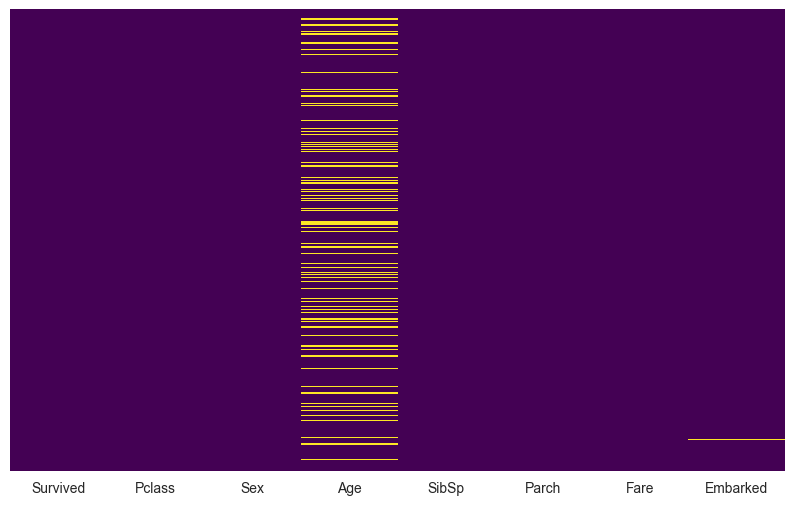

In [8]:
(
    sns.heatmap(
        train_data.isna(),
        yticklabels=False,
        cbar=False,
        cmap='viridis',
        
    )
)

In [9]:
train_data.Age.mean(), train_data.Age.median()

(29.69911764705882, 28.0)

In [10]:
train_data.Age.fillna(train_data.Age.median(), inplace=True)

In [11]:
train_data.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [12]:
train_data.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [13]:
train_data.Embarked.fillna('S', inplace=True)

In [14]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [15]:
del test_data['Cabin']
del test_data['Name']
del test_data['Ticket']

In [16]:
test_data.Age.fillna(test_data.Age.median(), inplace=True)

In [17]:
test_data.Fare.fillna(test_data.Fare.median(), inplace=True)

In [18]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


## Normalize the data

In [19]:
le = LabelEncoder()

train_data['Sex'] = le.fit_transform(train_data.Sex)
test_data['Sex'] = le.transform(test_data.Sex)


In [20]:
train_data['Embarked'] = le.fit_transform(train_data.Embarked)
test_data['Embarked'] = le.transform(test_data.Embarked)

le.inverse_transform([0, 1, 2])

array(['C', 'Q', 'S'], dtype=object)

In [21]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

age_bins = discretizer.fit(train_data[['Age']])

train_data['Age'] = age_bins.transform(train_data[['Age']])
test_data['Age'] = age_bins.transform(test_data[['Age']])

age_bins.bin_edges_

c:\Users\erik1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


array([array([ 0.42, 20.  , 28.  , 38.  , 80.  ])], dtype=object)

In [22]:
fare_bins = discretizer.fit(train_data[['Fare']])

train_data['Fare'] = fare_bins.transform(train_data[['Fare']])
test_data['Fare'] = fare_bins.transform(test_data[['Fare']])

fare_bins.bin_edges_

array([array([  0.    ,   7.8542,  10.5   ,  21.6792,  39.6875, 512.3292])],
      dtype=object)

In [23]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,1.0,1,0,0.0,2
1,1,1,0,3.0,1,0,4.0,0
2,1,3,0,1.0,0,0,1.0,2
3,1,1,0,2.0,1,0,4.0,2
4,0,3,1,2.0,0,0,1.0,2


In [36]:
X_train = train_data.drop('Survived', axis=1)
y_train = train_data.Survived

X_test = test_data.drop('PassengerId', axis=1)

X_train.shape, y_train.shape, X_test.shape

((891, 7), (891,), (418, 7))

In [73]:
x_mean = np.mean(X_train)
x_std = np.std(X_train)

X_train = (X_train - x_mean) / x_std
X_test = (X_test - x_mean) / x_std

c:\Users\erik1\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [74]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.827377,0.737695,-0.642946,0.432793,-0.473674,-1.459030,0.585954
1,-1.566107,-1.355574,1.339285,0.432793,-0.473674,1.404397,-1.942303
2,0.827377,-1.355574,-0.642946,-0.474545,-0.473674,-0.743174,0.585954
3,-1.566107,-1.355574,0.348170,0.432793,-0.473674,1.404397,0.585954
4,0.827377,0.737695,0.348170,-0.474545,-0.473674,-0.743174,0.585954


## Build the model

In [75]:
model = models.Sequential([
    layers.Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(.2),

    layers.Dense(10, activation='relu'),
    layers.Dropout(.2),

    layers.Dense(1, activation='sigmoid'),
])

In [76]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [77]:
x_val = X_train[:100]
partial_x_train = X_train[100:]

y_val = y_train[:100]
partial_y_train = y_train[100:]

x_val.shape, partial_x_train.shape, y_val.shape, partial_y_train.shape

((100, 7), (791, 7), (100,), (791,))

In [78]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=150,
    batch_size=32,
    validation_data=(x_val, y_val),
)

Epoch 1/150
25/25 [==============================] - 2s 20ms/step - loss: 0.7458 - binary_accuracy: 0.6157 - val_loss: 0.7394 - val_binary_accuracy: 0.5900
Epoch 2/150
25/25 [==============================] - 0s 5ms/step - loss: 0.6670 - binary_accuracy: 0.6245 - val_loss: 0.6847 - val_binary_accuracy: 0.5900
Epoch 3/150
25/25 [==============================] - 0s 5ms/step - loss: 0.6302 - binary_accuracy: 0.6308 - val_loss: 0.6499 - val_binary_accuracy: 0.5900
Epoch 4/150
25/25 [==============================] - 0s 5ms/step - loss: 0.6024 - binary_accuracy: 0.6574 - val_loss: 0.6231 - val_binary_accuracy: 0.6500
Epoch 5/150
25/25 [==============================] - 0s 5ms/step - loss: 0.5875 - binary_accuracy: 0.6764 - val_loss: 0.6063 - val_binary_accuracy: 0.6700
Epoch 6/150
25/25 [==============================] - 0s 5ms/step - loss: 0.5673 - binary_accuracy: 0.7092 - val_loss: 0.5923 - val_binary_accuracy: 0.7100
Epoch 7/150
25/25 [==============================] - 0s 5ms/step - lo

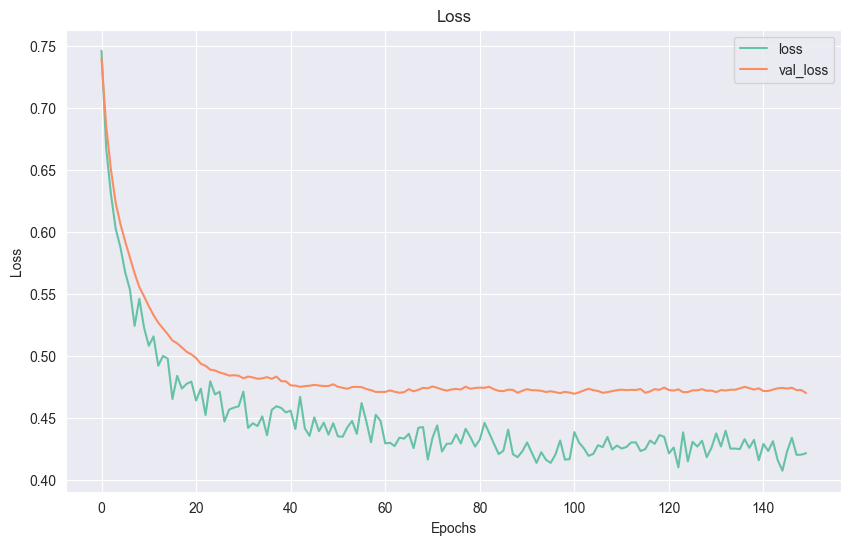

In [79]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

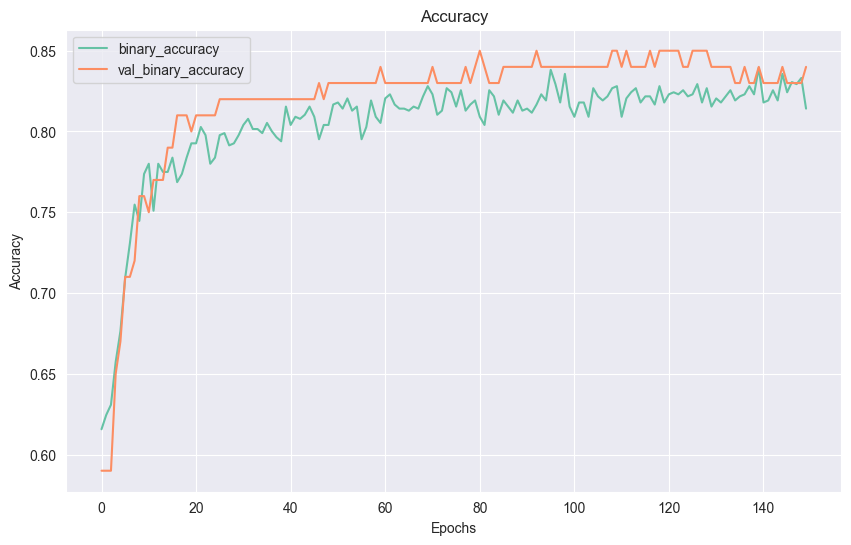

In [80]:
plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [81]:
model.evaluate(X_train, y_train)

28/28 [==============================] - 0s 3ms/step - loss: 0.3989 - binary_accuracy: 0.8418


[0.3988744020462036, 0.8417508602142334]

In [82]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 10)                80        
                                                                 
 dropout_11 (Dropout)        (None, 10)                0         
                                                                 
 dense_18 (Dense)            (None, 10)                110       
                                                                 
 dropout_12 (Dropout)        (None, 10)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 11        
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


In [86]:
y_pred = model.predict(X_test)
y_pred = y_pred > .5


14/14 [==============================] - 0s 3ms/step


In [87]:
y_pred = y_pred.astype(int).reshape(-1)
y_pred

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [88]:
final_submission = pd.DataFrame({
    'PassengerId': test_data.PassengerId,
    'Survived': y_pred
})

final_submission.to_csv('data/final_submission.csv', index=False)